#### Plotting ArcLeads and ice velocity contours for the different WRF-expts along transect in Beaufort Sea 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 27 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no



In [1]:
# allow plots to be interactive in the notebook
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
from pynextsim.projection_info import ProjectionInfo
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator

from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata

In [2]:
# Define functions

def get_transect(xr, start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)
    
#    print(ydist.shape, vtimes.shape, transect.shape)

    return ydist, vtimes, transect


def Interp2NextsimGrid(src_x, src_y, src_field, dst_x, dst_y, method='nearest'):
    '''
    Parameters:
    -----------
    src_x : 2D np.ndarray
        2D array (x,y) source points x-coords
    src_y : 2D np.ndarray
        2D array (x,y) source points y-coords    
    src_field : 2D np.ndarray
        Data values (x,y) on the source grid
    dst_x : 2D np.ndarray
        2D array (xi,yi) destination points x-coords
    dst_y : 2D np.ndarray
        2D array (xi,yi) destination points y-coords
    method : {‘linear’, ‘nearest’, ‘cubic’}
        interpolation method of scipy.interpolate.griddata (default is "nearest")

    '''
        
    # flatten 2D arrays
    points = np.array( (src_x.flatten(), src_y.flatten()) ).T

    vals = src_field.flatten()

    fld_interp = griddata(points, vals, (dst_x, dst_y), method=method)

    return fld_interp    
    
    

In [3]:
# load data

# setup directories 
rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
outdir =  rootdir + 'home/rheinlender/breakup-event-2013/figs/breakup-paper/'


arcleads_dir = rootdir + 'data/ARCLEADS/'
inpath = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs/", "expt_02_wrf20/outputs/","expt_03_wrf40/outputs/","expt_04_wrf80/outputs/"]

# open arcleads
arcleads = xr.open_dataset(arcleads_dir + 'ArcLeads_20130101-20130430.nc')  
latlon_grid =  xr.open_dataset(arcleads_dir + 'latlonmap.nc')
longitude = latlon_grid['longitude'][:]
latitude = latlon_grid['latitude'][:]

arcleads['longitude'] = longitude
arcleads['latitude'] = latitude

arcleads.rename({'latitude': 'lat', 'longitude': 'lon'})

# make lon and lat coordinates
arcleads.coords['lon'] = longitude
arcleads.coords['lat'] = latitude

leadmap = arcleads.leadMap
#leadmap.assign_coords({"lon":arcleads.longitude, "lat":arcleads.latitude})

# Open neXtSIM data
fl = inpath + expts[0] + 'Moorings.nc'
print("loading", fl)

mooring = xr.open_dataset(fl) # load data
nlon = mooring.longitude.values
nlat = mooring.latitude.values

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc


In [4]:
# regridding the Arcleads product to the Nextsim grid

proj = ProjectionInfo() # default nextsim projection

# get destination grid; x and y grid from nextsim
dst_x,dst_y = proj.pyproj(nlon, nlat) # init grid using x,y coords of grid

# get source grid; Project lon and lat from Arcleads to x,y grid using nextsim projection
src_x,src_y = proj.pyproj(arcleads['longitude'].values, arcleads['latitude'].values) 

#  source field
src_f = arcleads.leadMap

# use the shape from dst grid
nx,ny = dst_x.shape
nt = src_f.shape[0] 
dst_f = np.zeros((nt, nx, ny))
print(dst_f.shape)

# loop over time axis in source field
for t,time in enumerate(src_f.time):
    
    vals = src_f.isel(time=[t]).squeeze().values
    
    dst_f[t,:,:] = Interp2NextsimGrid(src_x, src_y, vals, dst_x, dst_y, method='nearest')
print('Interpolation done!')

# convert interpolated leadmap product back to DataArray
leadmap = dst_f
time = arcleads.indexes['time'].to_datetimeindex()
surface_classes = arcleads.attrs['surface classes']

ds = xr.Dataset(   
    data_vars=dict(
        leadmap=(["time", "y", "x"], leadmap)    ),
    coords=dict(
        time=time,    ),
    attrs=dict(
        description="ArcLeads product interpolated on to the nextsim grid.",
        surface_classes= surface_classes),
)


(120, 647, 719)
Interpolation done!


<ipython-input-4-783a66ffb022>:30: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  time = arcleads.indexes['time'].to_datetimeindex()


In [5]:

# Create slice variables for transect
start_time = '2013-02-13'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)

print("Get transect from", start_time, "to", end_time)
yvals, vtimes, lead_trans = get_transect(ds['leadmap'],start_time, end_time, xpoint, ypoint)


Get transect from 2013-02-13 to 2013-03-13


loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc


<ipython-input-6-7d03ca647093>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(vtimes, yvals, leadmsk.transpose(), cmap=cm_binary, shading='flat', alpha=0.5)


loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_02_wrf20/outputs/Moorings.nc
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_03_wrf40/outputs/Moorings.nc
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_04_wrf80/outputs/Moorings.nc


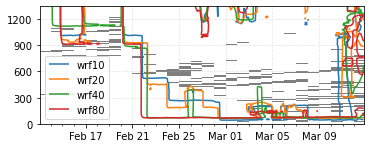

Saving /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/breakup-event-2013/figs/breakup-paper/MODISleads_icevel_0.05contour_transect_beaufort_all-expts.png


In [6]:
# Plot leads along transect and overlay ice velocity
plt.close('all')

# mask leads (leads=4)
leadmsk = xr.where(lead_trans==4, 1, 0)

cm_binary = plt.cm.get_cmap('binary')


fig, ax = plt.subplots(1,1,figsize=(6,5)) 
fig.subplots_adjust(bottom=0.0, top=0.98, left=0.13, right=0.88, wspace=0.08, hspace=0.0001)

# Plot leads from MODIS
im = ax.pcolormesh(vtimes, yvals, leadmsk.transpose(), cmap=cm_binary, shading='flat', alpha=0.5)

# overlay contour of ice velocity
clevs = [0.05]
cmap = plt.get_cmap("tab10")
expts_names = ["wrf10", "wrf20","wrf40","wrf80"]

for i, dirs in enumerate(expts):
    fl = inpath + dirs + 'Moorings.nc'
    print("loading", fl)

    xa = xr.open_dataset(fl) # load data

    # calculate ice velocity 
    xa['icevel'] = (xa['siu']**2 + xa['siv']**2)**0.5

    # get transect
    yvals2, vtimes2, icevel_trans = get_transect(xa['icevel'], start_time, end_time, xpoint, ypoint)

    # plot contour
    cline = ax.contour(vtimes2, yvals2, icevel_trans.transpose(), levels=clevs)
    cline.collections[0].set_color(cmap(i))
    cline.collections[0].set_label(expts_names[i]) # setting the label for legend

    #if i>=1 and i<3: # thin lines for wrf20 and wrf40
    #    cline.collections[0].set_linewidth(0.5)

# set labels
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
#ax.set_ylabel("y")
ax.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.

# add legend 
plt.legend(loc='lower left')
ax.grid(linestyle="--", alpha=0.3)
ax.set_xlim(vtimes2[0], vtimes2[-1])

#fig.subplots_adjust(bottom=0.18, top=0.90, left=0.08, right=0.9, wspace=0.01, hspace=0.01)
ax.set_position([0.13, 0.1088900986578969, 0.75, 0.3266594080526176])
plt.show()


# save figure
figname = os.path.join(outdir, 'MODISleads_icevel_0.05contour_transect_beaufort_all-expts.png')
os.makedirs(os.path.dirname(figname), exist_ok=True)
print(f'Saving {figname}')
#fig.savefig(figname,dpi=300, bbox_inches='tight')

In [7]:
fig.savefig(figname,dpi=300, bbox_inches='tight')